In [3]:
import numpy as np

In [4]:
n_training_data = int(2e2)
n_bits = 8

In [5]:
x_train = np.random.randint(2, size = (n_training_data, n_bits))
x_train = np.array(x_train, dtype = np.float32)
y_train = np.array([np.sum(x) % 2 for x in x_train], dtype = np.float32)

# Float32: Pytorch gives preference for this type instead of Float64 (I believe Float32 is optimal for GPUs...)

In [6]:
print(x_train[0:2]) # first two entries
print(y_train[0:2])

[[0. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0.]]
[1. 0.]


In [7]:
import torch
import torch.nn as nn # layer types
import torch.nn.functional as func # useful ML functions (activations) that are applied to layers

Defining a network as an objecct here

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        # super gives access to attributes in a superclass from the subclass that inherits from it
        self.fc1= nn.Linear(n_bits, 150) # fully connected 1
        self.fc2= nn.Linear(150, 1) # fully connected 2 - compression step

    def forward(self, x): # x is the input vector here
        h = func.relu(self.fc1(x)) # activation function on first layer
        y = torch.sigmoid(self.fc2(h)) # binary classification: sigmoid!
        return y
    
    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

Choosing where to run your training

In [10]:
model = Net().to(torch.device("cpu")) # inheritance!

In [11]:
import torch.optim as optim
learning_rate = 2e-1

Says stochastic but based on our inputs it won't be.

`model.parameters()` is inherited

In [12]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # not really going to do SGD...

converting numpy array to pytorch tensor

In [13]:
inputs = torch.from_numpy(x_train)

Targets are our y outputs of the training data.
Now we add another dimension just to interface properly with the other tensors.

In [14]:
targets = torch.from_numpy(y_train) # need an extra "superfluous" dimension
print(targets.size()) 
targets = torch.reshape(targets, (-1, 1))
print(targets.size()) 

torch.Size([200])
torch.Size([200, 1])


In [15]:
inputs.size()

torch.Size([200, 8])

In [20]:
model.forward(inputs).size()

torch.Size([200, 1])

Different kinds of loss functions. Here is binary cross-entropy loss function. 2nd line compares our network output and our training output

In [22]:
loss = torch.nn.BCELoss(reduction='mean')
loss(model.forward(inputs), targets)

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>)

epochs is the number of training steps we take. We only display the loss every 1000

In [23]:
num_epochs = int(1e4)
display_epochs = int(1e3)

In [24]:
obj_vals= []

for epoch in range(num_epochs):   
    obj_val = loss(model.forward(inputs), targets)
    
    optimizer.zero_grad() # clear any previous gradients
    obj_val.backward() # backprop step, calculates gradient values
    optimizer.step() # apply gradients to model parameters
    
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tLoss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))

Epoch [1000/10000]	Loss: 0.2104
Epoch [2000/10000]	Loss: 0.0583
Epoch [3000/10000]	Loss: 0.0261
Epoch [4000/10000]	Loss: 0.0153
Epoch [5000/10000]	Loss: 0.0104
Epoch [6000/10000]	Loss: 0.0077
Epoch [7000/10000]	Loss: 0.0060
Epoch [8000/10000]	Loss: 0.0049
Epoch [9000/10000]	Loss: 0.0041
Epoch [10000/10000]	Loss: 0.0035


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

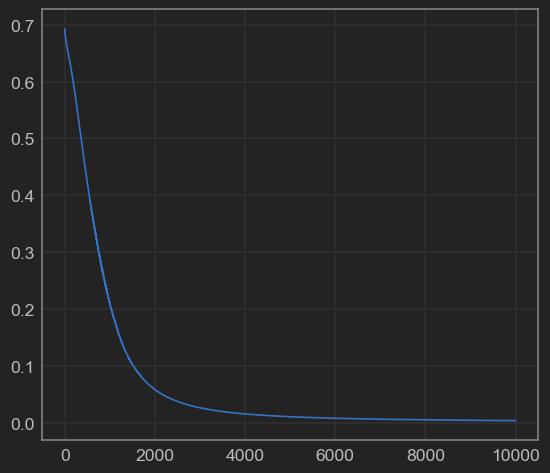

In [26]:
plt.plot(range(num_epochs), obj_vals)
plt.show()

Test data performs worse because it hasn't come across these specific combos before

In [29]:
n_test_data = int(1e2)
x_test = np.random.randint(2, size = (n_test_data, n_bits))
x_test = np.array(x_test, dtype = np.float32)
y_test = np.array([np.sum(x) % 2 for x in x_test], dtype = np.float32)

with torch.no_grad(): # stops all gradient calculations to make it faster
    inputs = torch.from_numpy(x_test)
    targets = torch.from_numpy(y_test)
    targets = torch.reshape(targets, (-1, 1))
    cross_val = loss(model.forward(inputs), targets)
    
print(cross_val)

tensor(0.2475)


Training and testing in one loop

In [31]:
obj_vals= []
cross_vals= []

model.reset() # reset your parameters

for epoch in range(num_epochs):
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)
    targets = torch.reshape(targets, (-1, 1))

    obj_val = loss(model.forward(inputs), targets)
    
    optimizer.zero_grad()
    obj_val.backward()
    optimizer.step()
    obj_vals.append(obj_val.item())

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Training Loss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))
            
    # as it trains check how well it tests
    with torch.no_grad(): 
        # don't track calculations in the following scope for the purposes of gradients
        inputs = torch.from_numpy(x_test)
        targets = torch.from_numpy(y_test)
        targets = torch.reshape(targets, (-1, 1))
        cross_val = loss(model.forward(inputs), targets)
        cross_vals.append(cross_val)

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Test Loss: {:.4f}'.format(epoch+1, num_epochs, cross_val.item()))
        
print('Final training loss: {:.4f}'.format(obj_vals[-1]))
print('Final test loss: {:.4f}'.format(cross_vals[-1]))

Epoch [1000/10000]	 Training Loss: 0.2867
Epoch [1000/10000]	 Test Loss: 0.5666
Epoch [2000/10000]	 Training Loss: 0.0826
Epoch [2000/10000]	 Test Loss: 0.3882
Epoch [3000/10000]	 Training Loss: 0.0327
Epoch [3000/10000]	 Test Loss: 0.3410
Epoch [4000/10000]	 Training Loss: 0.0179
Epoch [4000/10000]	 Test Loss: 0.3270
Epoch [5000/10000]	 Training Loss: 0.0116
Epoch [5000/10000]	 Test Loss: 0.3239
Epoch [6000/10000]	 Training Loss: 0.0084
Epoch [6000/10000]	 Test Loss: 0.3230
Epoch [7000/10000]	 Training Loss: 0.0064
Epoch [7000/10000]	 Test Loss: 0.3228
Epoch [8000/10000]	 Training Loss: 0.0051
Epoch [8000/10000]	 Test Loss: 0.3229
Epoch [9000/10000]	 Training Loss: 0.0043
Epoch [9000/10000]	 Test Loss: 0.3228
Epoch [10000/10000]	 Training Loss: 0.0036
Epoch [10000/10000]	 Test Loss: 0.3229
Final training loss: 0.0036
Final test loss: 0.3229


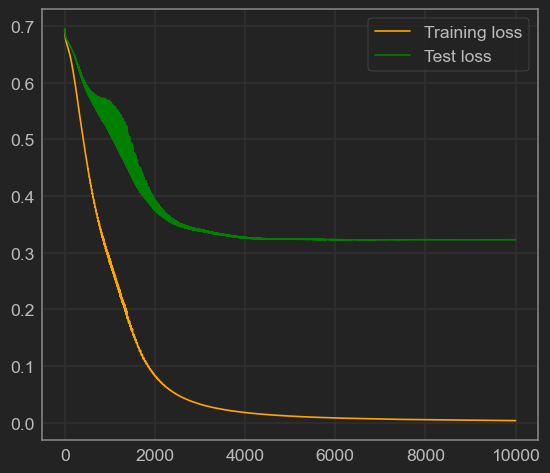

In [32]:
plt.plot(range(num_epochs), obj_vals, label= "Training loss", color="orange")
plt.plot(range(num_epochs), cross_vals, label= "Test loss", color= "green")
plt.legend()

This kind of plot (plus few sentances) is the "report" we need for assignment 2. One suggestion is to have a pdf of the plot in a results folders.